# **IEOR 4404  Simulation (Fall 2020)**

**Homework 6  [Total points: 80 Points]**


**Due 11:59 PM, Dec 13**

Homework 6 consists of application-oriented exercises focusing on:
* `simpy` simulation of systems
* Variance reduction

The steps to finish the homework:

*   Step 1: Answer your homework on Google Colab.
*   Step 2: Submit the copy on Google Assignment

Before you submit your assignment, make sure to re-run your code from the beginning. (You can do so by first clicking Runtime/Reset All Runtimes and then clicking Runtime/Run all)



In [4]:
#Your Name: Yi-Ping Tseng
#Your UNI: yt2690

In [1]:
!pip install sympy simpy pynverse -U

Requirement already up-to-date: sympy in /usr/local/lib/python3.6/dist-packages (1.7.1)
Requirement already up-to-date: simpy in /usr/local/lib/python3.6/dist-packages (4.0.1)
Requirement already up-to-date: pynverse in /usr/local/lib/python3.6/dist-packages (0.1.4.4)


In [2]:
#This imports all the packages you need for the homework
#Please run this first
import numpy as np


import scipy.special as spsp
import scipy.stats as spst

import matplotlib.pyplot as plt

%matplotlib inline

import sympy
!pip install simpy
import simpy
import copy
import collections

#Exercise 1 [30 Points]

##Setting


We are interested in simulating an application system using `simpy`. In this system, the unit of time is day, which may be non-integers.

An applicant may submit an application between $t=0$ and $t=100$. The submission time follows a homogeneous Poisson process with $\lambda=10$. Applications are then reviewed in the order that they are received. Each application needs to be reviewed by 2 people, potentially simultaneously.

At $t=90.375$ (9 am), a team of 10 admission officers will start the reviewing process. The time needed for an officer to review an application follows a uniform distribution between 0.05 and 0.1 days. After working for at least 0.375 days (9 hours), the officer will finish reviewing the current application  and then go home. Each officer resumes their work at 9 am the next day ($\lfloor t \rfloor +1.375$, where $t$ is the time that they went home).

The simulation stops when the officers finish reviewing all the applications submitted before $t=100$. 

**<font color="red">In this question, you are NOT allowed to use any built-in sampling function except np.random.rand() </font>**


##Q1. [25 Points]

For this system, we are interested in computing the average time between an application's submission and its review completion.

* Use `simpy` to construct the system. Make sure to comment on your code so that it is easy for the graders to understand your logic.
* Run the system once. Inside the function print out the following information for the first 50 submissions. For each submission, print out the 4 lines containing the following information:

>* `[submission id]  [start/finish] [time]  [reviewer 1 / reviewer 2]`

>* For example:`[1] [start] [90.375] [reviwer 1]`. means applicants 1's applications review process has started at t=0.4 by reviewer 1.

> * In total, you should print out 200 lines, These 200 lines should follow chronological order (time from smallest to largest). 


[Hint 1: Since all 10 officers are the identifical. Think carefully about how you can define your resources]

[Hint 2: It is useful to start two review processes for each application. One for reviewer 1 and one for reviwer 2. The review of an application will be over when both processes are processed]

[Hint 3: There are different ways to implement the system. The sample answer relied on priority resource to define requests with a higher priority to model the time period between going home and coming back to work for each worker]




In [3]:
def review(env, review_type, submit_id, resourceList, data, debug=False):
  # making request for all officers
  requestList = [r.request(priority=0) for r in resourceList]
  # selecting the officers who are available
  result = yield simpy.AnyOf(env, requestList)

  # directly assign to the first available officer
  process_index = None
  not_taken = True
  for index, rqt in enumerate(requestList):
    if rqt in result and not_taken:
      # memorize who is the first available officer
      process_index = index
      not_taken = False
    elif rqt in result and not_taken is False:
      # release the request from other available officers
      resourceList[index].release(rqt)
    else:
      # cancel the request if the officer is not availble
      rqt.cancel()

  # start processing the submission
  if submit_id < 50 and debug:
    print('id: %.f\t\t start time: %.3f\t\t reviewer %.f by officer %.f' % (submit_id, env.now, review_type, process_index))
  service_time = np.random.rand() * 0.05 + 0.05
  yield env.timeout(service_time)
  resourceList[process_index].release(requestList[process_index])
  if submit_id < 50 and debug:
    print('id: %.f\t\t finish time: %.3f\t\t reviewer %.f by officer %.f' % (submit_id, env.now, review_type, process_index))

  # collecting the completion time for reviews
  data[submit_id]['review ' + str(review_type)] = env.now


  # since the working hours is from 9~18, which is 0.375 to 0.75
  # we have to make sure all officers will call a day off after 18 o'clock (t=0.75)
  if env.now - np.floor(env.now) >= 0.375 + 0.375:
    # print('-'*20, 'end of a day at %.2f for %.f officer' % (env.now, process_index), '-'*20)
    rest_rqt = resourceList[process_index].request(priority=-1)
    yield rest_rqt
    # adding 1.375 means we are letting them come back to work at tmr's 9 o'clock
    yield env.timeout(1.375 + np.floor(env.now) - env.now)
    resourceList[process_index].release(rest_rqt)



def arrival(env, resourceList, data, submission_arrival_lambda=10, end_time=100, debug=False):
  submit_id = 0
  arrivalList = []
  time = 0
  # make sure we only accept submission before t=100
  while time <= end_time:
    # the inter-arrival of submission
    inter_arrival = -1/submission_arrival_lambda * np.log(np.random.rand())
    time += inter_arrival

    # store the subission time for each arrival
    data[submit_id]['submit'] = time
    arrivalList.append(submit_id)
    # differentiate the submission by giving them accumulative ID
    submit_id += 1

  # start reviewing the submission after t=90.375
  yield env.timeout(90.375)
  while True:
    # stop the process when every submission are reviewed by two officers
    if len(arrivalList) == 0:
      break

    # reviewing the submission by chronological order 
    submit_id = arrivalList.pop(0)
    # using `&` by making sure there will be two reviewers for each submission
    env.process(review(env, 1, submit_id, resourceList, data, debug)) & env.process(review(env, 2, submit_id, resourceList, data, debug))

In [4]:
def system(debug=False):
  env = simpy.Environment()
  # setting priority resource to make sure the officers leave when they work after 9 hours
  officer_1 = simpy.PriorityResource(env, capacity=1)
  officer_2 = simpy.PriorityResource(env, capacity=1)
  officer_3 = simpy.PriorityResource(env, capacity=1)
  officer_4 = simpy.PriorityResource(env, capacity=1)
  officer_5 = simpy.PriorityResource(env, capacity=1)
  officer_6 = simpy.PriorityResource(env, capacity=1)
  officer_7 = simpy.PriorityResource(env, capacity=1)
  officer_8 = simpy.PriorityResource(env, capacity=1)
  officer_9 = simpy.PriorityResource(env, capacity=1)
  officer_10 = simpy.PriorityResource(env, capacity=1)
  resourceList = [
    officer_1, officer_2, officer_3, 
    officer_4, officer_5, officer_6, 
    officer_7, officer_8, officer_9, officer_10
  ]


  data = collections.defaultdict(dict)
  submission_arrival_lambda = 10
  end_time = 100
  env.process(arrival(env, resourceList, data, submission_arrival_lambda=submission_arrival_lambda, end_time=end_time, debug=debug))
  env.run()
  return data

In [5]:
data = system(debug=True)

id: 0		 start time: 90.375		 reviewer 1 by officer 0
id: 0		 start time: 90.375		 reviewer 2 by officer 1
id: 1		 start time: 90.375		 reviewer 1 by officer 2
id: 1		 start time: 90.375		 reviewer 2 by officer 3
id: 2		 start time: 90.375		 reviewer 1 by officer 4
id: 2		 start time: 90.375		 reviewer 2 by officer 5
id: 3		 start time: 90.375		 reviewer 1 by officer 6
id: 3		 start time: 90.375		 reviewer 2 by officer 7
id: 4		 start time: 90.375		 reviewer 1 by officer 8
id: 4		 start time: 90.375		 reviewer 2 by officer 9
id: 0		 finish time: 90.427		 reviewer 1 by officer 0
id: 5		 start time: 90.427		 reviewer 1 by officer 0
id: 2		 finish time: 90.431		 reviewer 2 by officer 5
id: 5		 start time: 90.431		 reviewer 2 by officer 5
id: 1		 finish time: 90.440		 reviewer 1 by officer 2
id: 6		 start time: 90.440		 reviewer 1 by officer 2
id: 1		 finish time: 90.441		 reviewer 2 by officer 3
id: 6		 start time: 90.441		 reviewer 2 by officer 3
id: 2		 finish time: 90.446		 reviewer 1 b

In [6]:
result = []

for k, m in data.items():
  complete_time = max(m['review 1'], m['review 2'])
  total = complete_time - m['submit']
  result.append(total)
  if k < 5 or k > len(data) - 5:
    print('%.f -- submit time: %.2f, complete time: %.2f, total time: %.2f' % (k, m['submit'], complete_time, total))

print('\n\n')
print('the average completion time is %.5f' % np.mean(result))
print('the maximum completion time is %.5f for submission id: %.f' % (np.max(result), np.argmax(result)))
print('the minimum completion time is %.5f for submission id: %.f' % (np.min(result), np.argmin(result)))

0 -- submit time: 0.02, complete time: 90.46, total time: 90.44
1 -- submit time: 0.20, complete time: 90.44, total time: 90.24
2 -- submit time: 0.23, complete time: 90.45, total time: 90.21
3 -- submit time: 0.38, complete time: 90.46, total time: 90.08
4 -- submit time: 0.49, complete time: 90.47, total time: 89.98
980 -- submit time: 99.62, complete time: 125.74, total time: 26.12
981 -- submit time: 99.65, complete time: 125.74, total time: 26.10
982 -- submit time: 99.73, complete time: 125.78, total time: 26.05
983 -- submit time: 100.13, complete time: 125.77, total time: 25.64



the average completion time is 58.50323
the maximum completion time is 90.44419 for submission id: 0
the minimum completion time is 25.63920 for submission id: 983


##Q2. [5 Points]

* Comment out the print functions. Simulate the system 3 times and print out the system output each time. Again, the system output should be the average time between an application's submission and its review completion.


In [7]:
def simulation(N=3):
  result = []
  dataList = [system() for _ in range(N)]

  for data in dataList:
    tmp = 0
    for k, m in data.items():
      complete_time = max(m['review 1'], m['review 2'])
      total = complete_time - m['submit']
      tmp += total
    # adding one to k is because our id starts from 0
    result.append(tmp / (k + 1))

  return result

simulation()

[57.61760468793722, 56.778923290803384, 59.32306270332542]

# Exercise 2 [50 Points]

##Setting
A company has 10 machines. At the beginning, all 10 machines all working properly. For each machine, after $\Delta t$ hours of operating, it will break down. This inter-breakdown time $\Delta t$ follows $ Exp(\lambda=0.1)$.

When a machine breaks down, this machine will immediately be taken to the maintenance room. The maintenance room can only fix one machine at a time. The machines will be fixed following first come first serve. The time it takes to fix the machine follows $Exp(\lambda=1)$.

After the machine is fixed, the machine will be sent back to the operation room immediately to perform tasks.  After $\Delta t$ hours of operating, the machine will break down again. Again, $\Delta t \sim Exp(\lambda=0.1)$.

**<font color="red">In this question, you are NOT allowed to use any built-in sampling function except np.random.rand() </font>**


##Q1. [20 points]

* Simulate the system using `simpy`. The simulation should stop when the number of operating machines goes below 7. For the system output, return the length of time from $t=0$ to the end of simulation. Make sure to comment on your code so that it is easy for the graders to understand your logic.
* Run the system 1000 times. Plot the distribution of the system output. 
* Report the lower bound, upper bound, and the length of the 95% confidence interval for the expected value of the system output.


In [8]:
def break_arrival(env, resource, id, breakList, debug=False):
  break_lmbda = 0.1
  while True:
    # the breakage arrival for each machine
    inter_arrival = -1/break_lmbda * np.log(np.random.rand())
    yield env.timeout(inter_arrival)
    if debug:
      breakList.append(id)
      print('the machine %.f is broken at \t\t t=%.2f' % (id, env.now))
    
    # sending the broken machine to the maintenance room
    # using `yield` to avoid the next arrival before repairment
    yield env.process(repair(env, resource, id, breakList, debug=debug))
  

def repair(env, resource, id, breakList, debug=False):
  # calculate the estimated fixing time for the broken machine
  lmbda_service = 1
  inter_arrival = -1/lmbda_service*np.log(np.random.rand())

  # creating repairing request for the broken machine
  rqt = resource.request()
  # this check the number of broken machine should below or equal to 3
  # otherwise, the number of operating machines goes below 7
  if debug:
    print('-'*50, '\t the number of broken machine is %.f \t\t ' % (len(resource.users) + len(resource.queue)), breakList)
  if len(resource.users) + len(resource.queue) > 3:
    raise simpy.Interrupt("the number of operating machines goes below 7!")

  # repairing the breakage
  yield rqt
  yield env.timeout(inter_arrival)
  # release the repairment request
  resource.release(rqt)
  if debug:
    print('the machine %.f is repaired at \t\t t=%.2f' % (id, env.now))
    breakList.pop(0)


def system(debug=False):
  env = simpy.Environment()
  breakList = []
  # the maintenance room has only one capacity
  resource = simpy.Resource(env, capacity=1)
  # breakage process for 10 machines
  env.process(break_arrival(env, resource, id=1, breakList=breakList, debug=debug))
  env.process(break_arrival(env, resource, id=2, breakList=breakList, debug=debug))
  env.process(break_arrival(env, resource, id=3, breakList=breakList, debug=debug))
  env.process(break_arrival(env, resource, id=4, breakList=breakList, debug=debug))
  env.process(break_arrival(env, resource, id=5, breakList=breakList, debug=debug))
  env.process(break_arrival(env, resource, id=6, breakList=breakList, debug=debug))
  env.process(break_arrival(env, resource, id=7, breakList=breakList, debug=debug))
  env.process(break_arrival(env, resource, id=8, breakList=breakList, debug=debug))
  env.process(break_arrival(env, resource, id=9, breakList=breakList, debug=debug))
  env.process(break_arrival(env, resource, id=10, breakList=breakList, debug=debug))
  try:
    env.run()
  # stop the system when the number of operating machines goes below 7
  except simpy.Interrupt as e:
    if debug:
      print(str(e.cause))
    return env.now

In [9]:
system(debug=True)

the machine 8 is broken at 		 t=2.08
-------------------------------------------------- 	 the number of broken machine is 1 		  [8]
the machine 8 is repaired at 		 t=2.20
the machine 2 is broken at 		 t=5.07
-------------------------------------------------- 	 the number of broken machine is 1 		  [2]
the machine 2 is repaired at 		 t=5.43
the machine 6 is broken at 		 t=5.77
-------------------------------------------------- 	 the number of broken machine is 1 		  [6]
the machine 6 is repaired at 		 t=6.25
the machine 2 is broken at 		 t=6.84
-------------------------------------------------- 	 the number of broken machine is 1 		  [2]
the machine 2 is repaired at 		 t=6.93
the machine 5 is broken at 		 t=7.54
-------------------------------------------------- 	 the number of broken machine is 1 		  [5]
the machine 8 is broken at 		 t=7.58
-------------------------------------------------- 	 the number of broken machine is 2 		  [5, 8]
the machine 5 is repaired at 		 t=8.21
the machin

11.493450140224803

95% confidence interval 13.854851685683872 15.511188056852525
mean 14.683019871268199
width of 95% confidence interval 1.6563363711686527


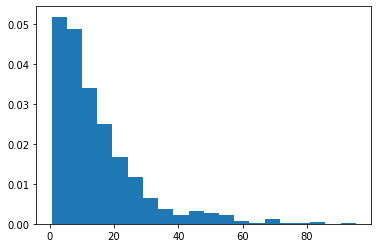

In [10]:
N = 1000
samples = np.array([system() for _ in range(N)])
plt.hist(samples, bins=20, density=True)

mean = np.mean(samples)
std = np.std(samples,ddof=1)
lower = mean - spst.norm.ppf(0.975) * std/N**0.5
upper = mean + spst.norm.ppf(0.975) * std/N**0.5
print("95% confidence interval", lower, upper)
print("mean", mean)
print("width of 95% confidence interval", upper-lower)

##Q2. [10 Points]

Apply antithetic method to the fixing time and the inter-breakdown time. 

* Report the lower bound, upper bound, and the width of the 95% confidence interval for the expected value of the system output.


In [11]:
def break_arrival(env, resource, id, break_random_state, repair_random_state, simu_type, breakList, debug=False):
  break_lmbda = 0.1
  while True:
    # making antithetic samples for different simu_type for negative correlation
    u = break_random_state.rand()
    if simu_type:
      u = 1 - u

    inter_arrival = -1/break_lmbda * np.log(u)
    yield env.timeout(inter_arrival)
    if debug:
      breakList.append(id)
      print('the machine %.f is broken at \t\t t=%.2f' % (id, env.now))
    yield env.process(repair(env, resource, id, repair_random_state, simu_type, breakList, debug=debug))
  

def repair(env, resource, id, repair_random_state, simu_type, breakList, debug=False):
  lmbda_service = 1
  # making antithetic samples for different simu_type for negative correlation
  u = repair_random_state.rand()
  if simu_type:
    u = 1 - u
  inter_arrival = -1/lmbda_service*np.log(u)

  rqt = resource.request()
  # this check the number of broken machine should below or equal to 3
  # otherwise, the number of operating machines goes below 7
  if debug:
    print('-'*50, '\t the number of broken machine is %.f \t\t ' % (len(resource.users) + len(resource.queue)), breakList)
  if len(resource.users) + len(resource.queue) > 3:
    raise simpy.Interrupt("the number of operating machines goes below 7!")

  yield rqt
  yield env.timeout(inter_arrival)
  resource.release(rqt)
  if debug:
    print('the machine %.f is repaired at \t\t t=%.2f' % (id, env.now))
    breakList.pop(0)


def system(break_random_state, repair_random_state, simu_type, debug=False):
  env = simpy.Environment()
  breakList = []
  resource = simpy.Resource(env, capacity=1)
  env.process(break_arrival(env, resource, 1, break_random_state, repair_random_state, simu_type, breakList, debug))
  env.process(break_arrival(env, resource, 2, break_random_state, repair_random_state, simu_type, breakList, debug))
  env.process(break_arrival(env, resource, 3, break_random_state, repair_random_state, simu_type, breakList, debug))
  env.process(break_arrival(env, resource, 4, break_random_state, repair_random_state, simu_type, breakList, debug))
  env.process(break_arrival(env, resource, 5, break_random_state, repair_random_state, simu_type, breakList, debug))
  env.process(break_arrival(env, resource, 6, break_random_state, repair_random_state, simu_type, breakList, debug))
  env.process(break_arrival(env, resource, 7, break_random_state, repair_random_state, simu_type, breakList, debug))
  env.process(break_arrival(env, resource, 8, break_random_state, repair_random_state, simu_type, breakList, debug))
  env.process(break_arrival(env, resource, 9, break_random_state, repair_random_state, simu_type, breakList, debug))
  env.process(break_arrival(env, resource, 10, break_random_state, repair_random_state, simu_type, breakList, debug))
  try:
    env.run()
  except simpy.Interrupt:
    return env.now


def simulation(debug=False):
  repair_org = np.random.RandomState()
  repair_anti = copy.copy(repair_org)

  break_org = np.random.RandomState()
  break_anti = copy.copy(break_org)
    
  output_1 = system(break_org, repair_org, 0, debug)
  if debug:
    print('*'*50)
    print('-'*17, 'antithetic part', '-'*16)
    print('*'*50)
  output_2 = system(break_anti, repair_anti, 1, debug)
  return (output_1 + output_2)/2

In [12]:
simulation(debug=True)

the machine 4 is broken at 		 t=0.92
-------------------------------------------------- 	 the number of broken machine is 1 		  [4]
the machine 7 is broken at 		 t=1.86
-------------------------------------------------- 	 the number of broken machine is 2 		  [4, 7]
the machine 4 is repaired at 		 t=2.72
the machine 4 is broken at 		 t=3.14
-------------------------------------------------- 	 the number of broken machine is 2 		  [7, 4]
the machine 5 is broken at 		 t=3.74
-------------------------------------------------- 	 the number of broken machine is 3 		  [7, 4, 5]
the machine 7 is repaired at 		 t=3.96
the machine 4 is repaired at 		 t=4.53
the machine 5 is repaired at 		 t=4.85
the machine 5 is broken at 		 t=5.13
-------------------------------------------------- 	 the number of broken machine is 1 		  [5]
the machine 8 is broken at 		 t=5.16
-------------------------------------------------- 	 the number of broken machine is 2 		  [5, 8]
the machine 5 is repaired at 		 t=5.4

15.059342396917916

95% confidence interval 14.160099357728189 15.140099032948608
mean 14.650099195338399
width of 95% confidence interval 0.9799996752204194


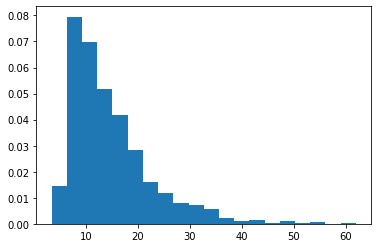

In [13]:
N = 1000
samples = np.array([simulation() for _ in range(N)])
plt.hist(samples, bins=20, density=True)

mean = np.mean(samples)
std = np.std(samples,ddof=1)
lower = mean - spst.norm.ppf(0.975) * std/N**0.5
upper = mean + spst.norm.ppf(0.975) * std/N**0.5
print("95% confidence interval", lower, upper)
print("mean", mean)
print("width of 95% confidence interval", upper-lower)

##Q3. [10 Points]

Apply control variate method to the fixing time of the first breakdown machine.

* Report the lower bound, upper bound, and the width of the 95% confidence interval for the expected value of the system output.



In [14]:
def break_arrival(env, resource, id, fixing_timeList, breakList, debug=False):
  break_lmbda = 0.1
  while True:
    inter_arrival = -1/break_lmbda * np.log(np.random.rand())
    yield env.timeout(inter_arrival)
    if debug:
      breakList.append(id)
      print('the machine %.f is broken at \t\t t=%.2f' % (id, env.now))
    yield env.process(repair(env, resource, id, fixing_timeList, breakList, debug=debug))
  

def repair(env, resource, id, fixing_timeList, breakList, debug=False):
  lmbda_service = 1
  inter_arrival = -1/lmbda_service*np.log(np.random.rand())

  rqt = resource.request()
  # this check the number of broken machine should below or equal to 3
  # otherwise, the number of operating machines goes below 7
  if debug:
    print('-'*50, '\t the number of broken machine is %.f \t\t ' % (len(resource.users) + len(resource.queue)), breakList)
  if len(resource.users) + len(resource.queue) > 3:
    raise simpy.Interrupt("the number of operating machines goes below 7!")

  yield rqt
  yield env.timeout(inter_arrival)
  fixing_timeList.append(env.now)
  resource.release(rqt)
  if debug:
    print('the machine %.f is repaired at \t\t t=%.2f' % (id, env.now))
    breakList.pop(0)


def system(debug=False):
  env = simpy.Environment()
  breakList = []
  resource = simpy.Resource(env, capacity=1)
  # creating z variable (the first fixing time)
  first_fixing_time = -1 * np.log(np.random.rand())
  fixing_timeList = []

  env.process(break_arrival(env, resource, 1, fixing_timeList, breakList=breakList, debug=debug))
  env.process(break_arrival(env, resource, 2, fixing_timeList, breakList=breakList, debug=debug))
  env.process(break_arrival(env, resource, 3, fixing_timeList, breakList=breakList, debug=debug))
  env.process(break_arrival(env, resource, 4, fixing_timeList, breakList=breakList, debug=debug))
  env.process(break_arrival(env, resource, 5, fixing_timeList, breakList=breakList, debug=debug))
  env.process(break_arrival(env, resource, 6, fixing_timeList, breakList=breakList, debug=debug))
  env.process(break_arrival(env, resource, 7, fixing_timeList, breakList=breakList, debug=debug))
  env.process(break_arrival(env, resource, 8, fixing_timeList, breakList=breakList, debug=debug))
  env.process(break_arrival(env, resource, 9, fixing_timeList, breakList=breakList, debug=debug))
  env.process(break_arrival(env, resource, 10, fixing_timeList, breakList=breakList, debug=debug))
  try:
    env.run()
  except simpy.Interrupt:
    if len(fixing_timeList) == 0:
      fixing_timeList = [env.now]

    rest_of_time = env.now - fixing_timeList[0]
    return env.now, first_fixing_time, fixing_timeList[0], rest_of_time

In [15]:
system(debug=True)

the machine 10 is broken at 		 t=1.83
-------------------------------------------------- 	 the number of broken machine is 1 		  [10]
the machine 4 is broken at 		 t=3.52
-------------------------------------------------- 	 the number of broken machine is 2 		  [10, 4]
the machine 10 is repaired at 		 t=4.97
the machine 4 is repaired at 		 t=5.78
the machine 8 is broken at 		 t=8.21
-------------------------------------------------- 	 the number of broken machine is 1 		  [8]
the machine 4 is broken at 		 t=9.14
-------------------------------------------------- 	 the number of broken machine is 2 		  [8, 4]
the machine 7 is broken at 		 t=9.17
-------------------------------------------------- 	 the number of broken machine is 3 		  [8, 4, 7]
the machine 8 is repaired at 		 t=9.95
the machine 4 is repaired at 		 t=10.21
the machine 10 is broken at 		 t=10.39
-------------------------------------------------- 	 the number of broken machine is 2 		  [7, 10]
the machine 7 is repaired at 

(18.29404408703035, 1.213822317192933, 4.973394380927713, 13.320649706102637)

In [27]:
N = 1000
samples = np.array([system() for _ in range(N)])
output = samples[:, 0]
z = samples[:, 1]
x = samples[:, 2]
r = samples[:, 3]
c = -np.cov(x, z, ddof=1)[0, 1] / np.var(z, ddof=1)
y = x + c * (z - 1) + r

print(c, np.cov(x, z, ddof=1)[0, 1])

-0.06563040316296447 0.0629294316857719


95% confidence interval 13.376877654905938 14.816666741263026
mean 14.096772198084482
width of 95% confidence interval 1.439789086357088


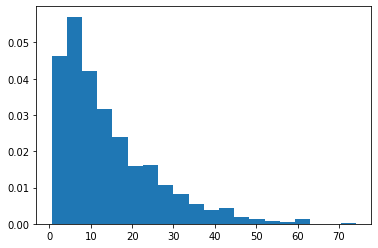

In [28]:
plt.hist(y, bins=20, density=True)

mean = np.mean(y)
std = np.std(y,ddof=1)
lower = mean - spst.norm.ppf(0.975) * std/N**0.5
upper = mean + spst.norm.ppf(0.975) * std/N**0.5
print("95% confidence interval", lower, upper)
print("mean", mean)
print("width of 95% confidence interval", upper-lower)

##Q4.  [10 points]

Now, let's continue from Q1. Suppose the maintenance room will be closed for 0.2 hours after every 0.8 hours of opening. During this time, the repairmen will not fix any machine. After the maintenance room reopens, the repairmen will resume fixing the machines. If at the time of break, the repairmen have taken $x'$ period of time to fix a machine and the amount of the time to fix the machine is $x$, the machine will now need $x-x'$ amount of time to get fixed.

* Run the system 1000 times. Plot the distribution of the time it takes for the number of operating machines to go below 7.

[hint: one solution is to define the maintenance room as a preemptive resource, and treat closing as a request]

In [29]:
# creating self-defined Exception for the close of maintenance room
class ClosedInterrupt(simpy.SimPyException):
  pass

In [30]:
def break_arrival(env, resource, id, breakList, debug=False):
  break_lmbda = 0.1
  while True:
    # the breakage arrival for each machine
    inter_arrival = -1/break_lmbda * np.log(np.random.rand())
    yield env.timeout(inter_arrival)
    breakList.append(id)
    if debug:
      print('t=%.2f: \t\tthe machine %.f is broken' % (env.now, id))
    # using `yield` to avoid the next breakage happens before it is repaired
    yield env.process(repair(env, resource, id, breakList, debug=debug))
  

def closed_arrival(env, resource, debug=False):
  while True:
    # close the maintenance room after every 0.8 hours
    yield env.timeout(0.8)
    if debug:
      print('t=%.2f: \t\t\033[94mclosing the maintenance room\033[0m' % env.now)

    # sending close request for repair with high priority and preempting right
    yield env.process(shutdown_repair(env, resource, debug))
    if debug:
      print('t=%.2f: \t\t\033[92mreopening the maintenance room\033[0m' % env.now)


def shutdown_repair(env, resource, debug=False):
  # defining a close request with high priority and preempting right
  rqt = resource.request(priority=-100, preempt=True)
  yield rqt
  # close the maintenance room for 0.2 hours
  yield env.timeout(0.2)
  # release the close request
  resource.release(rqt)


def repair(env, resource, id, breakList, priority=0, remaining_time=0, debug=False):
  # checking if it is a remaining request
  lmbda_service = 1
  if remaining_time > 0:
    # setting inter_arrival as the remaining fixing time
    # and setting preempt as True to make sure it is prioritized
    # the priority is decided when we call this function
    inter_arrival = remaining_time
    preempt = True
  else:
    # no remaining fixing time means it is a new repairing request
    # we randomly assign an fixing inter-arrival time 
    # setting preempt as False and priority as 0 (default)
    inter_arrival = -1/lmbda_service*np.log(np.random.rand())
    preempt = False
  

  rqt = resource.request(priority=priority, preempt=preempt)
  # this check the number of broken machine should below or equal to 3
  # otherwise, the number of operating machines goes below 7
  if debug:
    print('-'*90, '\t the number of broken machine is %.f \t\t ' % (len(breakList)), breakList)
  if len(breakList) > 3:
    raise ClosedInterrupt("the number of operating machines goes below 7!")

  yield rqt
  start_time = env.now
  if debug and remaining_time > 0:
    print('t=%.2f: \t\tthe machine %.f is waiting for repairing and the \033[1m remaining \033[0m fixing time is %.2f' % (start_time, id, inter_arrival))
  elif debug and remaining_time == 0:
    print('t=%.2f: \t\tthe machine %.f is waiting for repairing and the \033[1m estimated \033[0m fixing time is %.2f' % (start_time, id, inter_arrival))

  try:
    # if the repairment is not interrupt by the closure
    yield env.timeout(inter_arrival)

  except simpy.Interrupt as interrupt:
    # if the repairment request is interrupted by the closure
    # we first calculate the remaining fixing time

    # usage is the time the repairman already used to fix the machine
    # inter-arrival time is the total time for the repairman to fix the machine
    # the difference between inter-arrival and usage is the remaining fixing time
    usage = env.now - interrupt.cause.usage_since
    remaining_time = inter_arrival - usage

    # to make the system more clearly, we cancel the interrupted request 
    # and make a new one with high priority and preempting right
    rqt.cancel()
    # the highest priority is -3, which will always be smaller than the closure
    # we use `yield` so that it makes sure the repairman will finishing this request before other requests
    # since breakList is a queue (FIFO), 
    # we reverse the index and take it as negative value for priority
    yield env.process(repair(env, resource, id, breakList, priority=-1 * breakList[::-1].index(id), remaining_time=remaining_time, debug=debug))
    
  else:
    # only when the repairment is not interrupt by the closure
    # we then run this part
    # release the repairment request
    # and remove the machine from the breakList
    resource.release(rqt)
    breakList.pop(0)
    if debug:
      print('t=%.2f: \t\tthe machine %.f is repaired' % (env.now, id))


def system(debug=False):
  env = simpy.Environment()
  # breakList is a queue
  breakList = []
  # since the maintenance room will close for 0.2 hours every 0.8 hours
  # we set it as preemptive resource
  resource = simpy.PreemptiveResource(env, capacity=1)
  env.process(closed_arrival(env, resource, debug))
  env.process(break_arrival(env, resource, id=1, breakList=breakList, debug=debug))
  env.process(break_arrival(env, resource, id=2, breakList=breakList, debug=debug))
  env.process(break_arrival(env, resource, id=3, breakList=breakList, debug=debug))
  env.process(break_arrival(env, resource, id=4, breakList=breakList, debug=debug))
  env.process(break_arrival(env, resource, id=5, breakList=breakList, debug=debug))
  env.process(break_arrival(env, resource, id=6, breakList=breakList, debug=debug))
  env.process(break_arrival(env, resource, id=7, breakList=breakList, debug=debug))
  env.process(break_arrival(env, resource, id=8, breakList=breakList, debug=debug))
  env.process(break_arrival(env, resource, id=9, breakList=breakList, debug=debug))
  env.process(break_arrival(env, resource, id=10, breakList=breakList, debug=debug))
  try:
    env.run()
  except ClosedInterrupt as e:
    if debug:
      print(str(e))
    return env.now

In [34]:
system(debug=True)

t=0.42: 		the machine 2 is broken
------------------------------------------------------------------------------------------ 	 the number of broken machine is 1 		  [2]
t=0.42: 		the machine 2 is waiting for repairing and the  estimated  fixing time is 0.27
t=0.69: 		the machine 2 is repaired
t=0.80: 		closing the maintenance room
t=0.95: 		the machine 5 is broken
------------------------------------------------------------------------------------------ 	 the number of broken machine is 1 		  [5]
t=1.00: 		reopening the maintenance room
t=1.00: 		the machine 5 is waiting for repairing and the  estimated  fixing time is 0.11
t=1.11: 		the machine 5 is repaired
t=1.80: 		closing the maintenance room
t=2.00: 		reopening the maintenance room
t=2.32: 		the machine 6 is broken
------------------------------------------------------------------------------------------ 	 the number of broken machine is 1 		  [6]
t=2.32: 		the machine 6 is waiting for repairing and the  estimated  fixing time is

10.892422888538544

95% confidence interval 11.197408752062337 12.349873777285787
mean 11.773641264674062
width of 95% confidence interval 1.1524650252234494


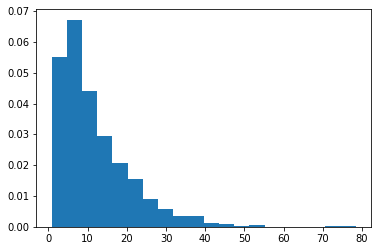

In [35]:
N = 1000
samples = np.array([system() for _ in range(N)])
plt.hist(samples, bins=20, density=True)

mean = np.mean(samples)
std = np.std(samples,ddof=1)
lower = mean - spst.norm.ppf(0.975) * std/N**0.5
upper = mean + spst.norm.ppf(0.975) * std/N**0.5
print("95% confidence interval", lower, upper)
print("mean", mean)
print("width of 95% confidence interval", upper-lower)